In [1]:
import SimpleITK as sitk
import numpy as np

def multires_registration(fixed_image, moving_image, initial_transform):    
    registration_method = sitk.ImageRegistrationMethod()
    #registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetInterpolator(sitk.sitkBSpline)
    #registration_method.SetInterpolator(sitk.sitkNearestNeighbor)
    #registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-4, convergenceWindowSize=55) # Reduce convergeMinimumValue=1e-6
    #increase convergenceWindowsize=10. http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html 
    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform, inPlace=True)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.Execute(fixed_image, moving_image)

    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

In [2]:
def resample_img(itk_image, is_label=False):

    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [1112,1112]

    out_spacing=[original_size[0] * (original_spacing[0] / out_size[0]), original_size[1] * (original_spacing[1] / out_size[1])]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [3]:
# Read the images
fixed_image = sitk.ReadImage('mama_fixed.png', sitk.sitkFloat32)
moving_image_or = sitk.ReadImage('mama_moving.png', sitk.sitkFloat32)
#fixed_image = sitk.ReadImage('piramide.dcm', sitk.sitkFloat32)[:,:,0]
#moving_image_or = sitk.ReadImage('MapaMama.dcm', sitk.sitkFloat32)[:,:,0]
moving_image = resample_img(moving_image_or, is_label=False)


fixed_matrix, moving_matrix = sitk.GetArrayFromImage(fixed_image), sitk.GetArrayFromImage(moving_image)

fixed_matrix = (fixed_matrix - np.mean(fixed_matrix))/np.std(fixed_matrix)
moving_matrix = (moving_matrix - np.mean(moving_matrix))/np.std(moving_matrix)

fixed_image = sitk.GetImageFromArray(fixed_matrix, isVector=False)
moving_image = sitk.GetImageFromArray(moving_matrix, isVector=False)

# Display the original images and resamples moving_image (onto the
# fixed_image grid using the identity transformation)

#sitk.Show(sitk.Resample(moving_image, fixed_image, sitk.Transform()), 'identity transform')

# Centered 2D affine transform and show the resampled moving_image using this transform.
registration_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.AffineTransform(2), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
#sitk.Show(sitk.Resample(moving_image, fixed_image, registration_transform), 'initial affine transform')


# Register using 2D affine initial transform that is overwritten
# and show the resampled moving_image using this transform.
multires_registration(fixed_image, moving_image, registration_transform)

registered_image = sitk.Resample(moving_image, fixed_image, registration_transform)

Final metric value: 0.038204711393250795
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 96.


In [4]:
sitk.Show(fixed_image, 'fixed')
sitk.Show(moving_image, 'moving')
sitk.Show(sitk.Resample(moving_image, fixed_image, registration_transform), 'final affine transform')

In [5]:
import matplotlib.pyplot as plt

# http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/05_Results_Visualization.html
zeros = sitk.Image(fixed_image.GetSize(), fixed_image.GetPixelID())
zeros.CopyInformation(fixed_image)

#sitk.Cast(sitk.Compose(fixed_image, moving_image, zeros), sitk.sitkVectorUInt8)
#sitk.Cast(sitk.Compose(fixed_image, moving_image, fixed_image), sitk.sitkVectorUInt8)
#sitk.Cast(sitk.Compose(fixed_image, 0.5*fixed_image+0.5*moving_image, moving_image), sitk.sitkVectorUInt8)]



fixed_matrix, registered_matrix, moving_matrix = sitk.GetArrayFromImage(fixed_image), sitk.GetArrayFromImage(registered_image), sitk.GetArrayFromImage(moving_image_or)
max_fixed, min_fixed = int(np.amax(fixed_matrix)), int(np.amin(fixed_matrix))
max_moving, min_moving = int(np.amax(moving_matrix)), int(np.amin(moving_matrix))
max_registered, min_registered = int(np.amax(registered_matrix)), int(np.amin(registered_matrix))



img1_255 = sitk.Cast(sitk.IntensityWindowing(fixed_image, windowMinimum=min_fixed, windowMaximum=max_fixed, outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
img2_255 = sitk.Cast(sitk.IntensityWindowing(registered_image, windowMinimum=min_registered, windowMaximum=max_registered, outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
img3_255 = sitk.Cast(sitk.IntensityWindowing(sitk.Resample(moving_image, fixed_image, sitk.Transform()), windowMinimum=min_moving, windowMaximum=max_moving, outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)


#sitk.Show(sitk.Cast(sitk.Compose(fixed_image, 0.5*fixed_image+0.5*registered_image, registered_image), sitk.sitkVectorUInt8), "fixed and moved")
#sitk.Show(sitk.Cast(sitk.Compose(fixed_image, 0.5*fixed_image+0.5*moving_image, moving_image), sitk.sitkVectorUInt8), "fixed and registered")

In [6]:
sitk.Show(sitk.Cast(sitk.Compose(img1_255, 0.5*img1_255+0.5*img2_255, img2_255), sitk.sitkVectorUInt8), "fixed and registered")
sitk.Show(sitk.Cast(sitk.Compose(img1_255, 0.5*img1_255+0.5*img3_255, img3_255), sitk.sitkVectorUInt8), "fixed and moved")

In [7]:
sitk.Show(sitk.CheckerBoard(img1_255, img2_255, [30,30,4]))

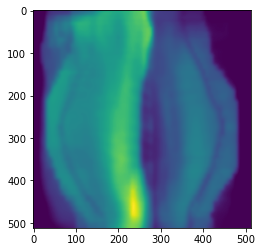

In [8]:
import pymedphys

fixed = sitk.GetArrayFromImage(img1_255)[300:-300, 300:-300]
registered = sitk.GetArrayFromImage(img2_255)[300:-300, 300:-300]

#registered[:,:300] = 0
#registered[:,-300:] = 0
#registered[:300,:] = 0
#registered[-300:,:] = 0

plt.imshow(fixed)

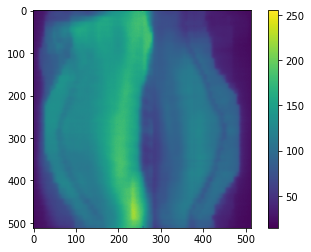

In [9]:
plt.imshow(registered)
plt.colorbar()

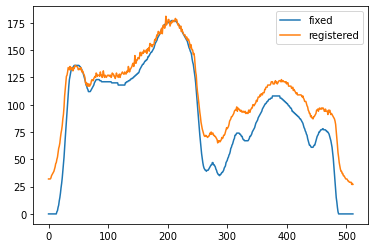

In [10]:
plt.plot(  fixed[int(np.shape(fixed)[0]/2),:], label="fixed"    )
plt.plot(  registered[int(np.shape(registered)[0]/2),:], label="registered"  )
plt.legend()
plt.show()

In [14]:
x= np.linspace(0,fixed.shape[0],fixed.shape[0])
y = np.linspace(0,fixed.shape[1],fixed.shape[1])

coords = (y, x)

gamma_options = {
    'dose_percent_threshold': 3,
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 20,
    'interp_fraction': 20,  # Should be 10 or more for more accurate results
    'max_gamma': 3,
    'random_subset': None,
    'local_gamma': False
}


gamma = pymedphys.gamma(
    coords, fixed,
    coords, registered,
    **gamma_options)
valid_gamma = gamma[~np.isnan(gamma)]

# ---------------------------------------------------------------------
# Passing rate determined here
# ---------------------------------------------------------------------

passing = 100 * np.sum(valid_gamma <= 1) / len(valid_gamma)

# ---------------------------------------------------------------------



Calcing using global normalisation point for gamma
Global normalisation set to 255 Gy
Global dose threshold set to [7.65] Gy ([3]%)
Distance threshold set to [3] mm
Lower dose cutoff set to 25.5 Gy (10%)

Current distance: 4.65 mm | Number of reference points remaining: 99123 | Points tested per reference point: 196 | RAM split count: 22

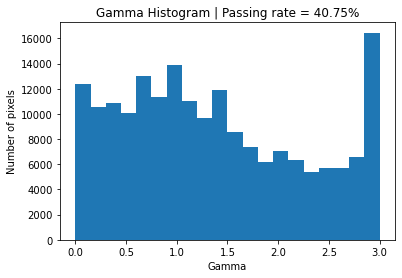

In [ ]:
plt.figure()
plt.title(f'Gamma Histogram | Passing rate = {passing:.2f}%')
plt.xlabel('Gamma')
plt.ylabel('Number of pixels')

plt.hist(valid_gamma, 20)
plt.show()

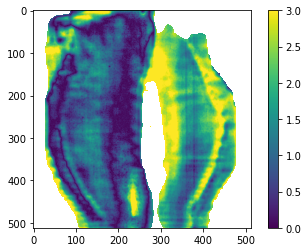

In [ ]:
plt.imshow(gamma)
plt.colorbar()